In [1]:
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from datetime import datetime
from imblearn.over_sampling import SMOTE

In [2]:
def parse_date(date_str):
    for fmt in ('%Y-%m-%d %H:%M', '%Y-%m-%d'):
        try:
            return datetime.strptime(date_str, fmt)
        except ValueError:
            continue
    print(f"Failed to parse date: {date_str}")
    return None

In [3]:
csv_files = [
    'L257959_bird_data.csv', 'L207315_bird_data.csv', 'L162766_bird_data.csv',
    'marymoor_park.csv', 'L321969_bird_data.csv', 'L298030_bird_data.csv',
    'L269461_bird_data.csv', 'L232479_bird_data.csv', 'L128530_bird_data.csv'
]

In [4]:
df_list = [pd.read_csv(file) for file in csv_files]
df = pd.concat(df_list, ignore_index=True)

# Strip extra spaces from column names
df.columns = df.columns.str.strip()

# Ensure 'Observation Date' column is parsed correctly as datetime
df['Observation Date'] = pd.to_datetime(df['Observation Date'], errors='coerce')

In [15]:
# Check if there are any missing values after parsing
df = df.dropna(subset=['Observation Date'])  # Drop rows with invalid dates

# Feature Engineering: Extract relevant features from 'Observation Date'
df['Hour'] = df['Observation Date'].dt.hour
df['Day'] = df['Observation Date'].dt.day
df['Month'] = df['Observation Date'].dt.month
df['Year'] = df['Observation Date'].dt.year

In [29]:
# Handle categorical features (Location and Species) by encoding them
df['Location'] = df['Location'].astype('category').cat.codes
df['Species'] = df['Species'].astype('category').cat.codes

# Calculate the frequency of each species (class)
species_counts = df['Species'].value_counts()

# Define a threshold for the minimum number of occurrences of a species
threshold = 50  # Adjust this based on your dataset

# Filter the dataframe to keep only the species with occurrences above the threshold
df_filtered = df[df['Species'].isin(species_counts[species_counts >= threshold].index)]

# Prepare your features and labels
X = df_filtered[['Hour', 'Day', 'Month', 'Year',  'Location']]  # Add 'Latitude' and 'Longitude'
y = df_filtered['Species']  # Target variable (Species)

In [30]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(y_train.value_counts())


Species
3      81
59     77
62     76
107    76
91     76
       ..
116    41
149    40
134    40
6      39
110    38
Name: count, Length: 77, dtype: int64


In [31]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Convert to DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train_res, label=y_train_res)
dtest = xgb.DMatrix(X_test, label=y_test)

Accuracy: 0.21212121212121213


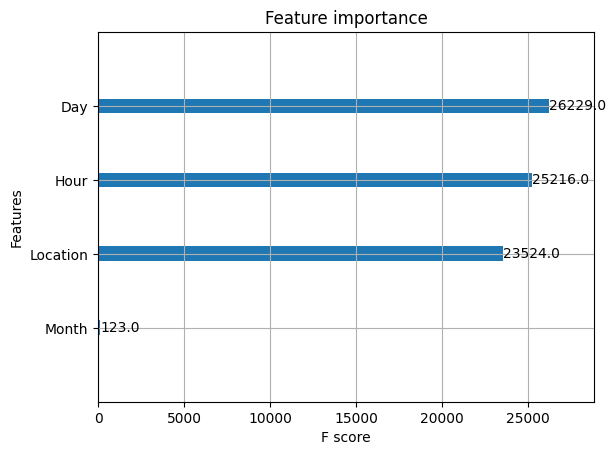

In [32]:
# Define hyperparameters for the model
params = {
    'objective': 'multi:softmax',  # Multi-class classification
    'num_class': len(df['Species'].unique()),  # Number of classes (species)
    'max_depth': 7,  # Maximum depth of the trees
    'eta': 0.1,  # Learning rate (step size)
    'subsample': 0.8,  # Fraction of samples to use for each tree
    'colsample_bytree': 0.8,  # Fraction of features to use for each tree
    'eval_metric': 'merror',  # Error rate metric for multi-class classification
    'seed': 42  # Random seed for reproducibility
}

# Train the XGBoost model with the given hyperparameters
num_round = 100  # Number of boosting rounds (trees)
bst = xgb.train(params, dtrain, num_round)

# Make predictions on the test set
y_pred = bst.predict(dtest)

# Convert predictions to integers (since the model outputs class probabilities)
y_pred = y_pred.astype(int)

# Evaluate the model's performance using accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Feature importance plot (optional)
import matplotlib.pyplot as plt
xgb.plot_importance(bst)
plt.show()

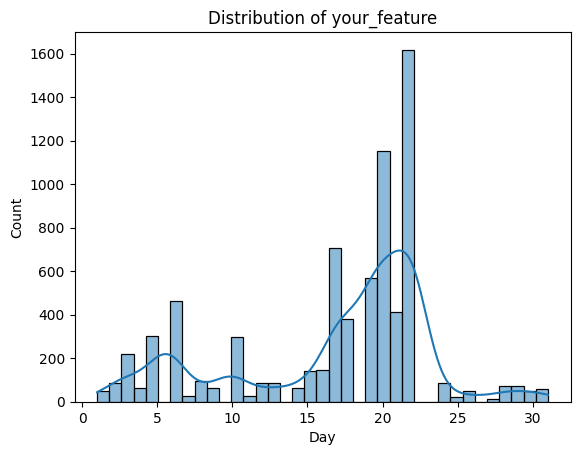

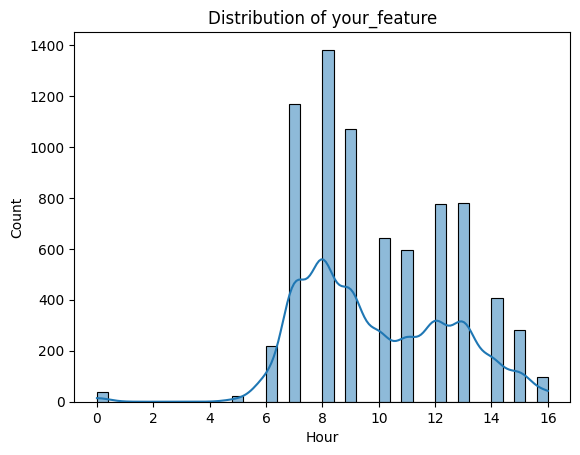

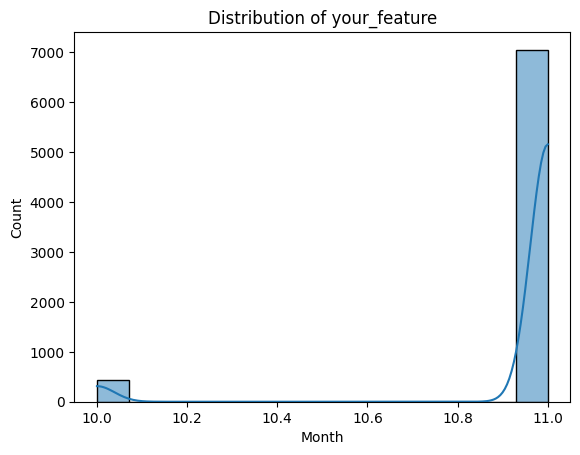

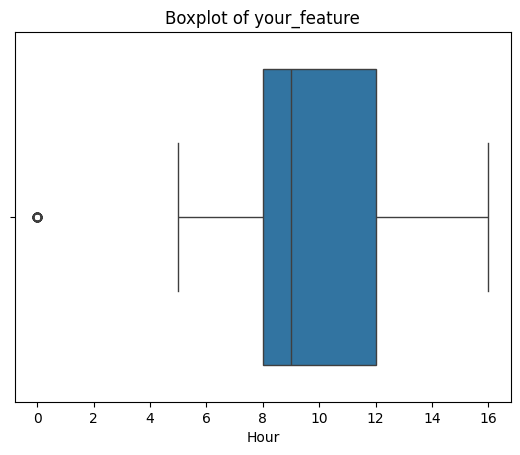

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the distribution using a histogram
sns.histplot(df['Day'], kde=True)
plt.title('Distribution of your_feature')
plt.show()

sns.histplot(df['Hour'], kde=True)
plt.title('Distribution of your_feature')
plt.show()

sns.histplot(df['Month'], kde=True)
plt.title('Distribution of your_feature')
plt.show()

# Box plot to check for outliers
sns.boxplot(x=df['Hour'])
plt.title('Boxplot of your_feature')
plt.show()